In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv("C:\REPOS\DL_Tutorial\data\Train.csv")

In [ ]:
df.columns
result = df[['Path','ClassId']]
result.columns
result.to_csv("GTSRBxandy.csv",index=False)

In [ ]:
result.tail()

In [2]:
# The German Traffic Sign Recognition Benchmark
#
# sample code for reading the traffic sign images and the
# corresponding labels
#
# example:
#            
# trainImages, trainLabels = readTrafficSigns('GTSRB/Training')
# print len(trainLabels), len(trainImages)
# plt.imshow(trainImages[42])
# plt.show()
#
# have fun, Christian

import matplotlib.pyplot as plt
import csv

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader)
        #gtReader.next() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels


In [3]:
X, y = readTrafficSigns("data/GTSRB/Final_Training/Images/")

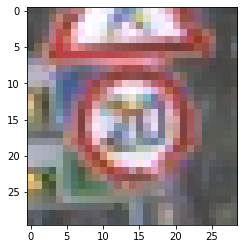

In [6]:
plt.imshow(X[0])

In [ ]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
#(X_train, X_train), (X_test, y_test) = load_data()

df = pd.DataFrame([X])
df2 = pd.DataFrame([y])

result = pd.concat([df, df2], axis=1)
print(result)
result.to_csv("GTSRB.csv")

## MODEL

In [4]:
import keras
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation
from tensorflow.keras.datasets import fashion_mnist
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import train_test_split
import time
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')


LOG_DIR = f"{int(time.time())}"

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [5]:
image_data = []
image_labels = []
data_dir = "C:\REPOS\DL_Tutorial\data"
NUM_CATEGORIES = 43

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)



In [6]:
print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [7]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [8]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [9]:
y_train = keras.utils.to_categorical(y_train, 43)
y_val = keras.utils.to_categorical(y_val, 43)


print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [12]:
%load_ext tensorboard

In [10]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

lr = 0.001
epochs = 10

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [36]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"]

KeyError: 'CUDA_VISIBLE_DEVICES'

In [37]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
history = model.fit(X_train, y_train, epochs=epochs,callbacks=[tensorboard_callback], validation_data=(X_val, y_val))
#history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs,callbacks=[tensorboard_callback], validation_data=(X_val, y_val))

Epoch 1/10
858/858 [==============================] - 9s 10ms/step - loss: 8.0923e-04 - accuracy: 0.9996 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 2/10


KeyboardInterrupt: 

# Learner

    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')

In [32]:
def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Conv2D(hp.Int('input_units',
                                min_value=8,
                                max_value=32,
                                step=8), (3, 3), input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(hp.Int('n_layers', 1, 4)):  # adding variation of layers.
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3)))
        model.add(Activation('relu'))

    model.add(Flatten()) 
    model.add(Dense(43))
    model.add(Activation("softmax"))

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [28]:
from tensorflow.keras.callbacks import TensorBoard

NAME = "GTSRB_CNN"

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

In [34]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [33]:
#X_train = X_train.reshape(-1, 30, 30, 1)
#X_val = X_val.reshape(-1, 30, 30, 1)

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR)


tuner.search(x=X_train,
             y=y_train,
             verbose=2, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=1,
             batch_size=32,
             callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(X_val, y_val))

Trial 40 Complete [00h 00m 06s]
val_accuracy: 0.9404913783073425

Best val_accuracy So Far: 0.9771316647529602
Total elapsed time: 00h 04m 05s
INFO:tensorflow:Oracle triggered exit
